# Pomegranate Disease Classification
## Data Exploration and Preprocessing

This notebook performs exploratory data analysis and preprocessing on a pomegranate disease dataset. The dataset contains images of pomegranates with various diseases: Alternaria, Anthracnose, Bacterial_Blight, Cercospora, and Healthy samples.

## 1. Import required libraries

In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
import random
import shutil
from tqdm import tqdm
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler
from sklearn.feature_extraction import image
from sklearn.decomposition import PCA
from scipy import stats

import warnings
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)
random.seed(42)

## 2. Define paths and constants

In [3]:
# Define paths
DATA_DIR = 'data/pomegranate'
OUTPUT_DIR = 'data/preprocessed'
IMAGE_SIZE = (224, 224)  # Standard input size for many CNNs

# Ensure output directory exists
os.makedirs(OUTPUT_DIR, exist_ok=True)

## 3. Data Loading and Exploration

In [4]:
def explore_dataset(data_dir):
    """Explore the dataset structure and return basic statistics"""
    classes = os.listdir(data_dir)
    classes = [cls for cls in classes if os.path.isdir(os.path.join(data_dir, cls))]
    print(f"Found {len(classes)} classes: {classes}")
    
    # Count images per class
    class_counts = {}
    image_paths = []
    labels = []
    
    for cls in classes:
        class_dir = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        class_counts[cls] = len(images)
        
        # Store image paths and labels
        for img in images:
            image_paths.append(os.path.join(class_dir, img))
            labels.append(cls)
    
    print("\nClass distribution:")
    for cls, count in class_counts.items():
        print(f"{cls}: {count} images")
    
    total_images = sum(class_counts.values())
    print(f"\nTotal number of images: {total_images}")
    
    return classes, class_counts, image_paths, labels

# Explore the dataset
classes, class_counts, image_paths, labels = explore_dataset(DATA_DIR)

Found 5 classes: ['Alternaria', 'Anthracnose', 'Bacterial_Blight', 'Cercospora', 'Healthy']

Class distribution:
Alternaria: 886 images
Anthracnose: 1166 images
Bacterial_Blight: 966 images
Cercospora: 631 images
Healthy: 1450 images

Total number of images: 5099


### Visualize class distribution

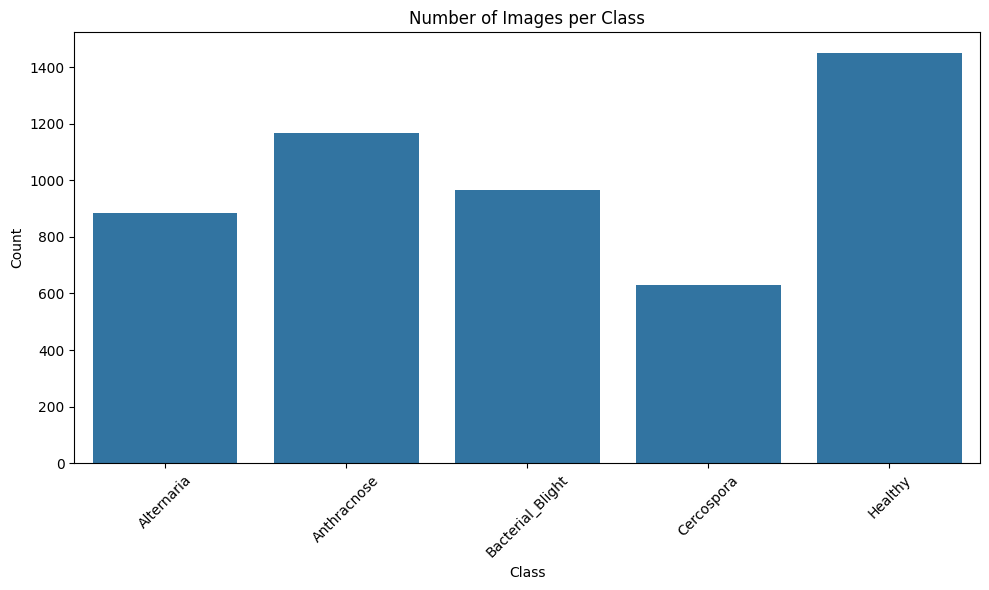

In [5]:
plt.figure(figsize=(10, 6))
sns.barplot(x=list(class_counts.keys()), y=list(class_counts.values()))
plt.title('Number of Images per Class')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

## 4. Image Data Analysis
### 4.1 Examine Image Properties

In [6]:
def analyze_image_properties(image_paths, sample_size=100):
    """Analyze properties of a sample of images"""
    # Sample paths if there are too many
    if len(image_paths) > sample_size:
        sampled_paths = random.sample(image_paths, sample_size)
    else:
        sampled_paths = image_paths
    
    # Store image properties
    widths = []
    heights = []
    channels = []
    file_sizes = []  # in KB
    formats = []
    
    for img_path in tqdm(sampled_paths, desc="Analyzing images"):
        try:
            # Get file size
            file_size = os.path.getsize(img_path) / 1024  # KB
            file_sizes.append(file_size)
            
            # Get image format
            img_format = os.path.splitext(img_path)[1][1:].upper()
            formats.append(img_format)
            
            # Open with PIL to get dimensions
            img = Image.open(img_path)
            width, height = img.size
            widths.append(width)
            heights.append(height)
            
            # Get number of channels
            img_array = np.array(img)
            if len(img_array.shape) == 2:  # Grayscale
                channels.append(1)
            else:  # Color (RGB or RGBA)
                channels.append(img_array.shape[2])
                
        except Exception as e:
            print(f"Error analyzing {img_path}: {e}")
    
    # Create DataFrame with the properties
    image_properties = pd.DataFrame({
        'width': widths,
        'height': heights,
        'channels': channels,
        'file_size_kb': file_sizes,
        'format': formats
    })
    
    return image_properties

# Analyze a sample of images
image_properties = analyze_image_properties(image_paths)

# Display summary statistics
print("\nImage Properties Summary:")
print(image_properties.describe())

# Count of image formats
print("\nImage Formats:")
format_counts = image_properties['format'].value_counts()
print(format_counts)

# Count of number of channels
print("\nImage Channels:")
channel_counts = image_properties['channels'].value_counts()
print(channel_counts)

Analyzing images: 100%|██████████| 100/100 [00:07<00:00, 13.47it/s]


Image Properties Summary:
        width  height  channels  file_size_kb
count   100.0   100.0     100.0    100.000000
mean   3120.0  3120.0       3.0    866.661709
std       0.0     0.0       0.0    124.783217
min    3120.0  3120.0       3.0    632.756836
25%    3120.0  3120.0       3.0    778.292236
50%    3120.0  3120.0       3.0    852.405273
75%    3120.0  3120.0       3.0    956.967529
max    3120.0  3120.0       3.0   1170.654297

Image Formats:
format
JPG    100
Name: count, dtype: int64

Image Channels:
channels
3    100
Name: count, dtype: int64


### 4.2 Check for missing or corrupted images

In [7]:
def check_corrupted_images(image_paths):
    """Check for corrupted or unreadable images"""
    corrupted = []
    
    for img_path in tqdm(image_paths, desc="Checking image integrity"):
        try:
            img = Image.open(img_path)
            img.verify()  # Verify it's an image
            
            # Try to load it with OpenCV as well
            _ = cv2.imread(img_path)
            
        except Exception as e:
            corrupted.append((img_path, str(e)))
    
    return corrupted

# Check for corrupted images
corrupted_images = check_corrupted_images(image_paths)

if corrupted_images:
    print(f"Found {len(corrupted_images)} corrupted images:")
    for path, error in corrupted_images[:10]:  # Show first 10
        print(f"{path}: {error}")
    if len(corrupted_images) > 10:
        print(f"...and {len(corrupted_images) - 10} more")
else:
    print("No corrupted images found.")

Checking image integrity: 100%|██████████| 5099/5099 [04:05<00:00, 20.73it/s]

No corrupted images found.


### 4.3 Visualize sample images from each class

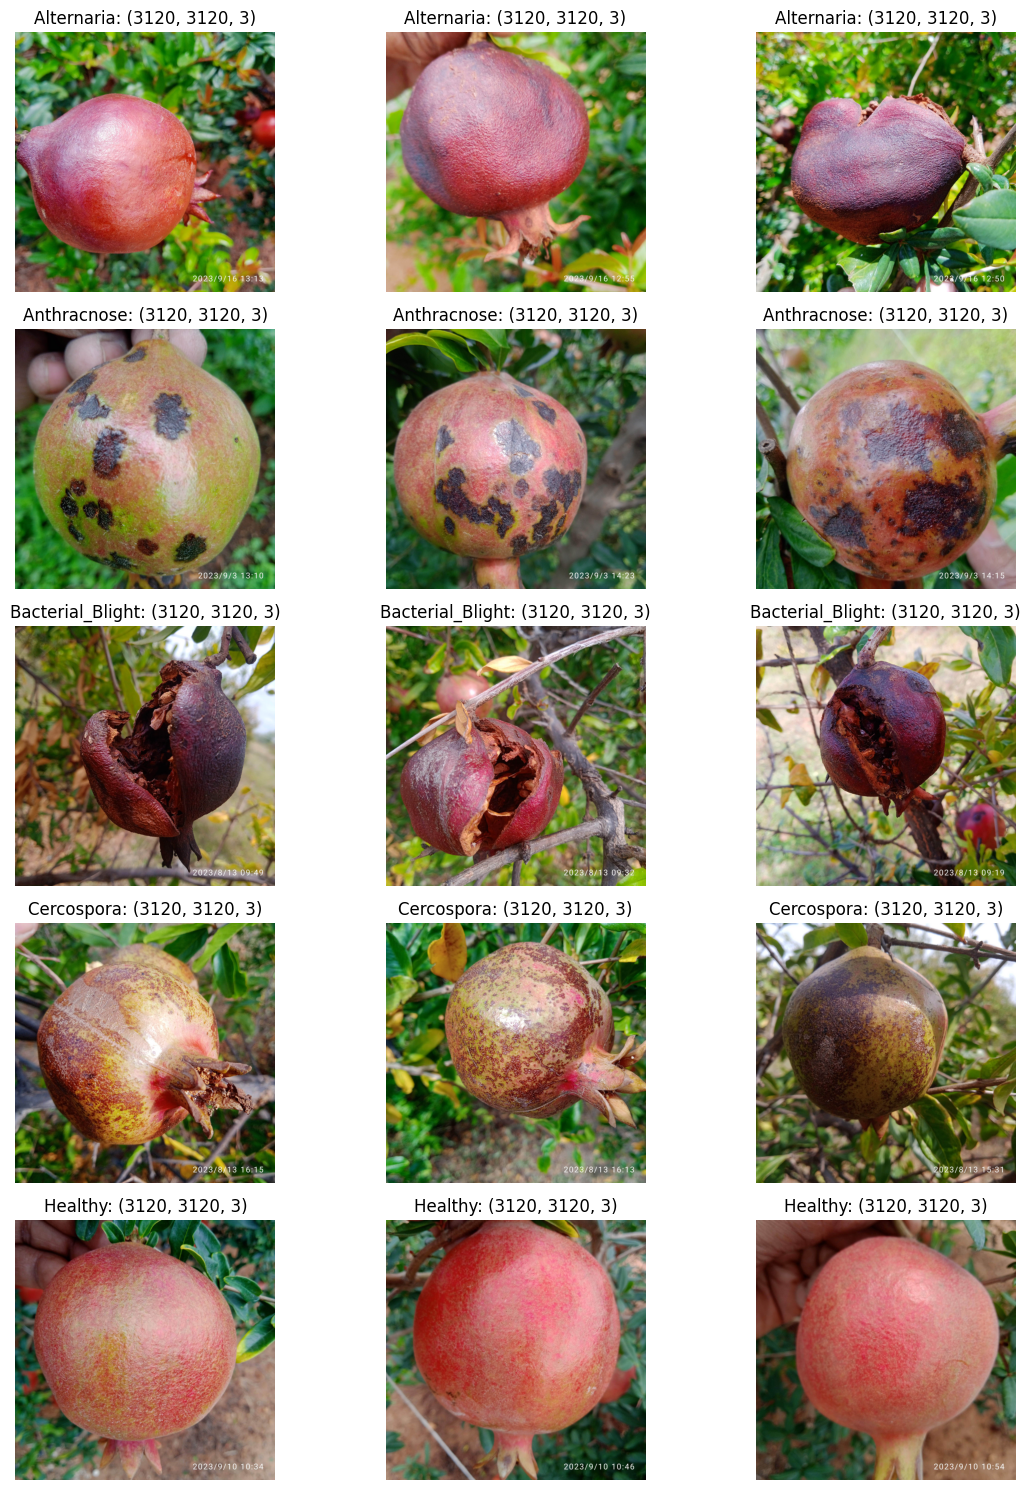

In [8]:
def visualize_samples(classes, data_dir, samples_per_class=2):
    """Visualize sample images from each class"""
    num_classes = len(classes)
    fig, axes = plt.subplots(num_classes, samples_per_class, figsize=(samples_per_class*4, num_classes*3))
    
    for i, cls in enumerate(classes):
        class_dir = os.path.join(data_dir, cls)
        images = [f for f in os.listdir(class_dir) 
                 if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
        
        # Sample randomly
        if len(images) >= samples_per_class:
            sample_images = random.sample(images, samples_per_class)
        else:
            sample_images = images
        
        # Display each sample
        for j, img_name in enumerate(sample_images):
            if j < samples_per_class:  # Ensure we don't exceed the subplot count
                img_path = os.path.join(class_dir, img_name)
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                
                axes[i, j].imshow(img)
                axes[i, j].set_title(f"{cls}: {img.shape}")
                axes[i, j].axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize sample images
visualize_samples(classes, DATA_DIR, samples_per_class=3)

### 4.4 Analyze pixel value distribution

In [9]:
def analyze_pixel_distribution(image_paths, num_samples=50):
    """Analyze the distribution of pixel values in a sample of images"""
    # Randomly sample images
    if len(image_paths) > num_samples:
        sampled_paths = random.sample(image_paths, num_samples)
    else:
        sampled_paths = image_paths
    
    # Store pixel statistics for each image
    pixel_stats = []
    
    for img_path in tqdm(sampled_paths, desc="Analyzing pixel distributions"):
        try:
            # Read image with OpenCV
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            
            # Compute channel-wise statistics
            r_mean, r_std = img[:,:,0].mean(), img[:,:,0].std()
            g_mean, g_std = img[:,:,1].mean(), img[:,:,1].std()
            b_mean, b_std = img[:,:,2].mean(), img[:,:,2].std()
            
            # Compute brightness
            brightness = (0.299 * img[:,:,0] + 0.587 * img[:,:,1] + 0.114 * img[:,:,2]).mean()
            
            # Store class label
            label = os.path.basename(os.path.dirname(img_path))
            
            pixel_stats.append({
                'image': os.path.basename(img_path),
                'label': label,
                'r_mean': r_mean,
                'g_mean': g_mean,
                'b_mean': b_mean,
                'r_std': r_std,
                'g_std': g_std,
                'b_std': b_std,
                'brightness': brightness
            })
            
        except Exception as e:
            print(f"Error analyzing {img_path}: {e}")
    
    # Convert to DataFrame
    df_pixel_stats = pd.DataFrame(pixel_stats)
    
    return df_pixel_stats

# Analyze pixel distributions
df_pixel_stats = analyze_pixel_distribution(image_paths)

Analyzing pixel distributions: 100%|██████████| 50/50 [00:19<00:00,  2.56it/s]


### 4.5 Statistical description of pixel data

In [11]:
# Display summary statistics for pixel distributions
print("Pixel Statistics Summary:")
print(df_pixel_stats.describe())

# Group by class and compute mean statistics
class_pixel_stats = df_pixel_stats.groupby('label').mean(numeric_only=True)
print("\nMean Pixel Statistics by Class:")
print(class_pixel_stats)

Pixel Statistics Summary:
           r_mean      g_mean      b_mean      r_std      g_std      b_std  \
count   50.000000   50.000000   50.000000  50.000000  50.000000  50.000000   
mean   128.817492  105.345129   80.654784  63.790114  46.499708  51.198590   
std     14.700172   16.417352   13.375329  10.424078   6.721824   7.458597   
min    100.116284   60.220193   42.496253  36.660708  33.057793  36.982398   
25%    116.644428   95.142364   72.161947  57.149703  41.142862  45.233270   
50%    129.960940  108.439360   80.059494  63.216589  46.318399  49.826172   
75%    139.640895  116.338369   89.678339  69.979634  51.574827  57.589286   
max    163.520603  141.226826  112.449119  89.619053  58.146618  67.267210   

       brightness  
count   50.000000  
mean   109.548666  
std     10.584076  
min     89.066141  
25%    102.472281  
50%    109.216149  
75%    115.597348  
max    144.475187  

Mean Pixel Statistics by Class:
                      r_mean      g_mean     b_mean      r

### 4.6 Visualize distributions and detect outliers

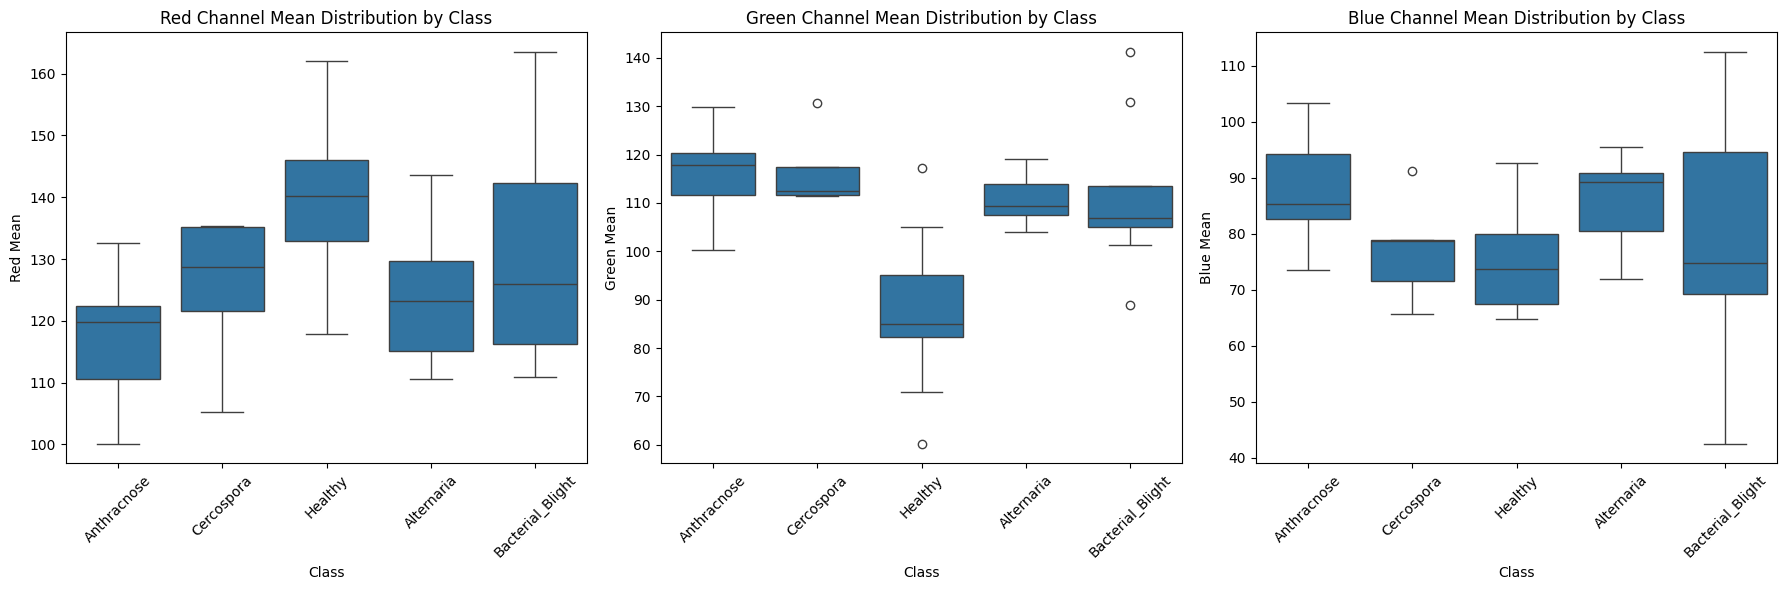

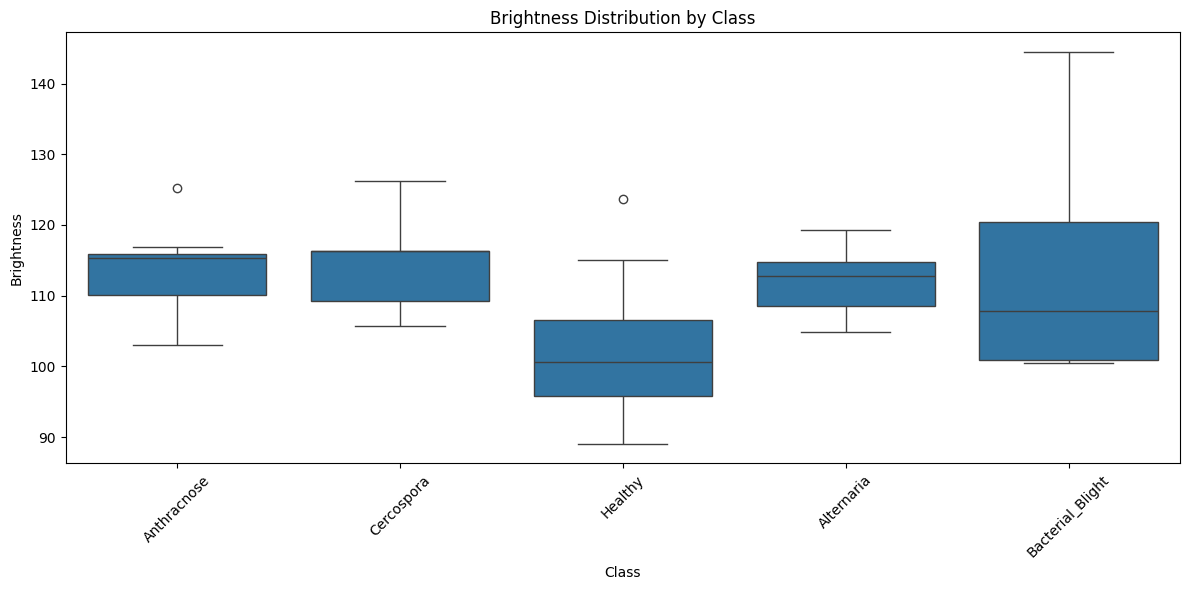

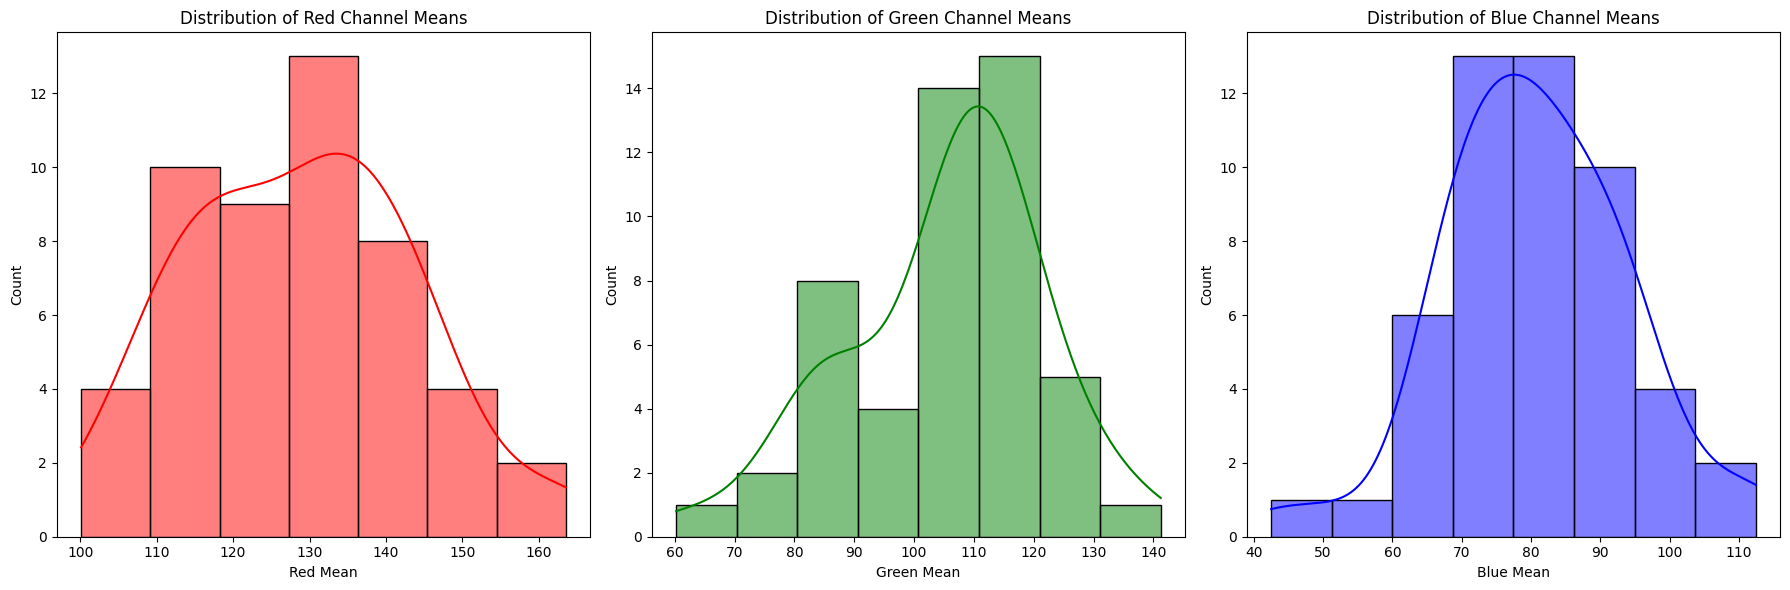

In [12]:
# Box plots to visualize distribution and detect outliers
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.boxplot(x='label', y='r_mean', data=df_pixel_stats, ax=axes[0])
axes[0].set_title('Red Channel Mean Distribution by Class')
axes[0].set_xlabel('Class')
axes[0].set_ylabel('Red Mean')
axes[0].tick_params(axis='x', rotation=45)

sns.boxplot(x='label', y='g_mean', data=df_pixel_stats, ax=axes[1])
axes[1].set_title('Green Channel Mean Distribution by Class')
axes[1].set_xlabel('Class')
axes[1].set_ylabel('Green Mean')
axes[1].tick_params(axis='x', rotation=45)

sns.boxplot(x='label', y='b_mean', data=df_pixel_stats, ax=axes[2])
axes[2].set_title('Blue Channel Mean Distribution by Class')
axes[2].set_xlabel('Class')
axes[2].set_ylabel('Blue Mean')
axes[2].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# Brightness distribution
plt.figure(figsize=(12, 6))
sns.boxplot(x='label', y='brightness', data=df_pixel_stats)
plt.title('Brightness Distribution by Class')
plt.xlabel('Class')
plt.ylabel('Brightness')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Histograms for RGB channels
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

sns.histplot(df_pixel_stats['r_mean'], kde=True, ax=axes[0], color='red')
axes[0].set_title('Distribution of Red Channel Means')
axes[0].set_xlabel('Red Mean')

sns.histplot(df_pixel_stats['g_mean'], kde=True, ax=axes[1], color='green')
axes[1].set_title('Distribution of Green Channel Means')
axes[1].set_xlabel('Green Mean')

sns.histplot(df_pixel_stats['b_mean'], kde=True, ax=axes[2], color='blue')
axes[2].set_title('Distribution of Blue Channel Means')
axes[2].set_xlabel('Blue Mean')

plt.tight_layout()
plt.show()

### 4.7 Identify outliers using Z-score method

In [13]:
def detect_outliers_zscore(df, threshold=3):
    """Detect outliers using Z-score method"""
    # Features to check for outliers
    features = ['r_mean', 'g_mean', 'b_mean', 'brightness']
    
    # Store outliers
    outliers = {}
    
    for feature in features:
        # Calculate Z-scores
        z_scores = stats.zscore(df[feature])
        
        # Find outliers
        outlier_indices = np.where(np.abs(z_scores) > threshold)[0]
        outliers[feature] = outlier_indices
        
        print(f"Feature '{feature}': {len(outlier_indices)} outliers detected using Z-score")
    
    # Find common outliers across features
    all_outlier_indices = set()
    for indices in outliers.values():
        all_outlier_indices.update(indices)
    
    print(f"\nTotal unique outlier images: {len(all_outlier_indices)}")
    
    return outliers, list(all_outlier_indices)

# Detect outliers
outliers, outlier_indices = detect_outliers_zscore(df_pixel_stats)

# Display some of the outlier images
if outlier_indices:
    print("\nSample of outlier images:")
    outlier_samples = df_pixel_stats.iloc[outlier_indices[:min(5, len(outlier_indices))]]
    print(outlier_samples[['image', 'label', 'r_mean', 'g_mean', 'b_mean', 'brightness']])

Feature 'r_mean': 0 outliers detected using Z-score
Feature 'g_mean': 0 outliers detected using Z-score
Feature 'b_mean': 0 outliers detected using Z-score
Feature 'brightness': 1 outliers detected using Z-score

Total unique outlier images: 1

Sample of outlier images:
                      image             label      r_mean      g_mean  \
27  IMG_20230813_095440.jpg  Bacterial_Blight  163.520603  141.226826   

        b_mean  brightness  
27  111.248949  144.475187  


### 4.8 Identify outliers using IQR method

In [14]:
def detect_outliers_iqr(df, threshold=1.5):
    """Detect outliers using IQR method"""
    # Features to check for outliers
    features = ['r_mean', 'g_mean', 'b_mean', 'brightness']
    
    # Store outliers
    outliers = {}
    
    for feature in features:
        # Calculate Q1, Q3, and IQR
        Q1 = df[feature].quantile(0.25)
        Q3 = df[feature].quantile(0.75)
        IQR = Q3 - Q1
        
        # Define bounds
        lower_bound = Q1 - threshold * IQR
        upper_bound = Q3 + threshold * IQR
        
        # Find outliers
        outlier_mask = (df[feature] < lower_bound) | (df[feature] > upper_bound)
        outlier_indices = np.where(outlier_mask)[0]
        outliers[feature] = outlier_indices
        
        print(f"Feature '{feature}': {len(outlier_indices)} outliers detected using IQR")
    
    # Find common outliers across features
    all_outlier_indices = set()
    for indices in outliers.values():
        all_outlier_indices.update(indices)
    
    print(f"\nTotal unique outlier images: {len(all_outlier_indices)}")
    
    return outliers, list(all_outlier_indices)

# Detect outliers using IQR
outliers_iqr, outlier_indices_iqr = detect_outliers_iqr(df_pixel_stats)

Feature 'r_mean': 0 outliers detected using IQR
Feature 'g_mean': 1 outliers detected using IQR
Feature 'b_mean': 1 outliers detected using IQR
Feature 'brightness': 1 outliers detected using IQR

Total unique outlier images: 3


### 4.9 Visualize relationships using scatter plots

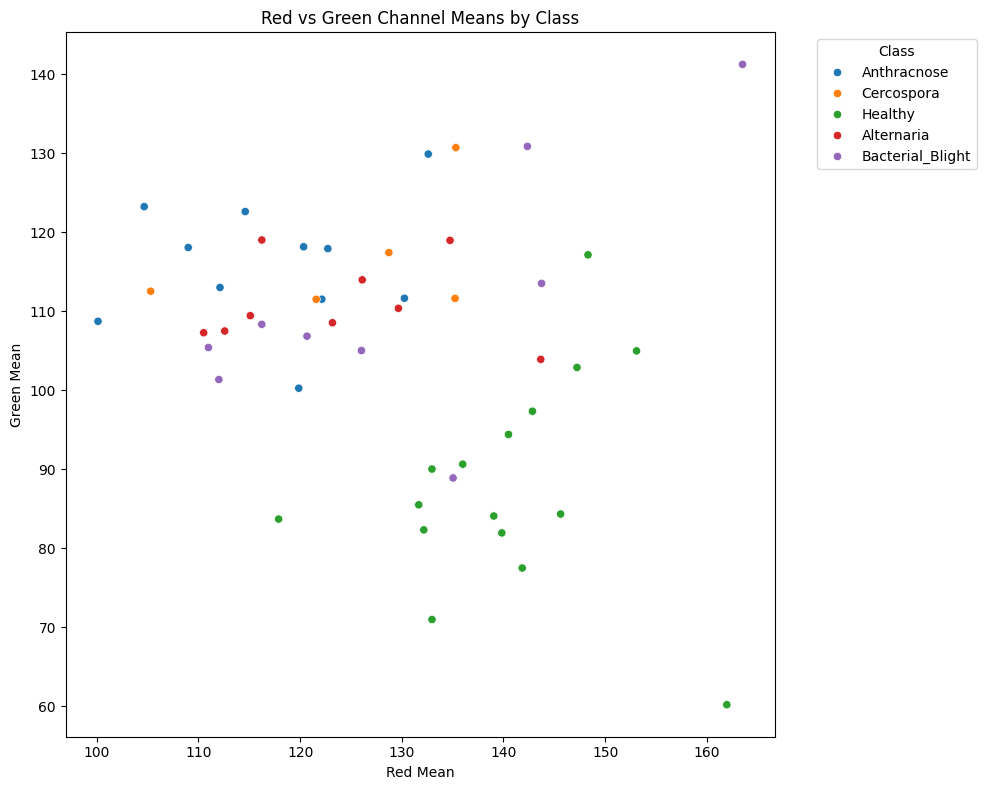

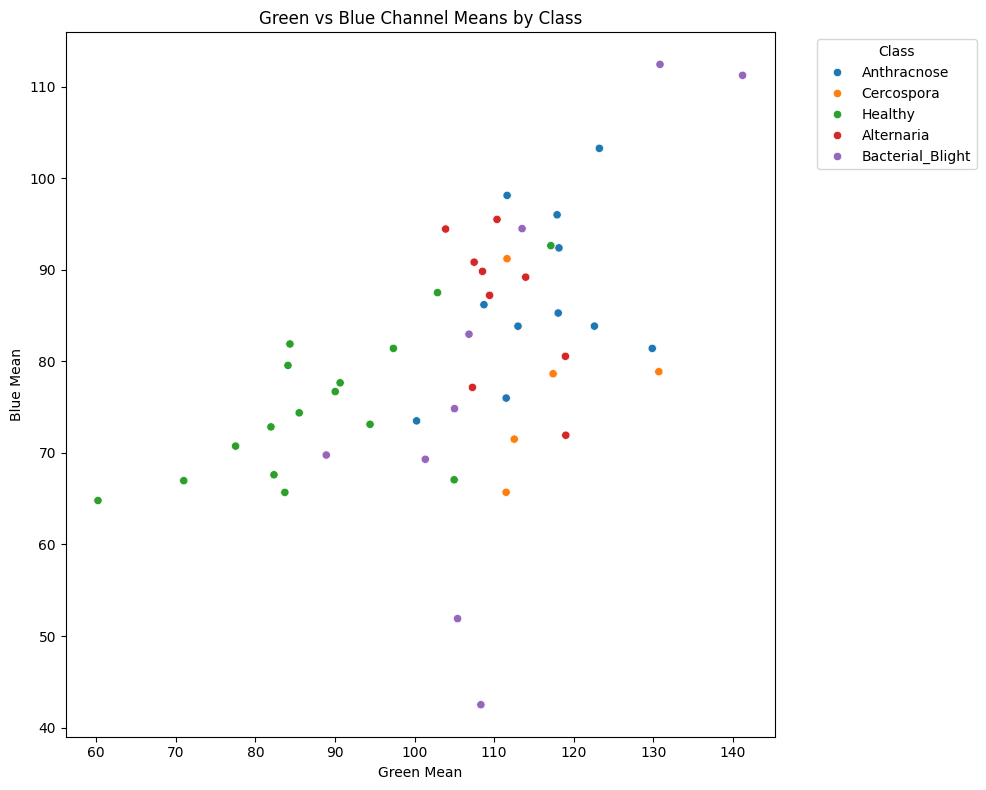

In [15]:
# Scatter plot of Red vs Green channel means, colored by class
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='r_mean', y='g_mean', hue='label', data=df_pixel_stats)
plt.title('Red vs Green Channel Means by Class')
plt.xlabel('Red Mean')
plt.ylabel('Green Mean')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Scatter plot of Green vs Blue channel means, colored by class
plt.figure(figsize=(10, 8))
scatter = sns.scatterplot(x='g_mean', y='b_mean', hue='label', data=df_pixel_stats)
plt.title('Green vs Blue Channel Means by Class')
plt.xlabel('Green Mean')
plt.ylabel('Blue Mean')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

### 4.10 Correlation analysis

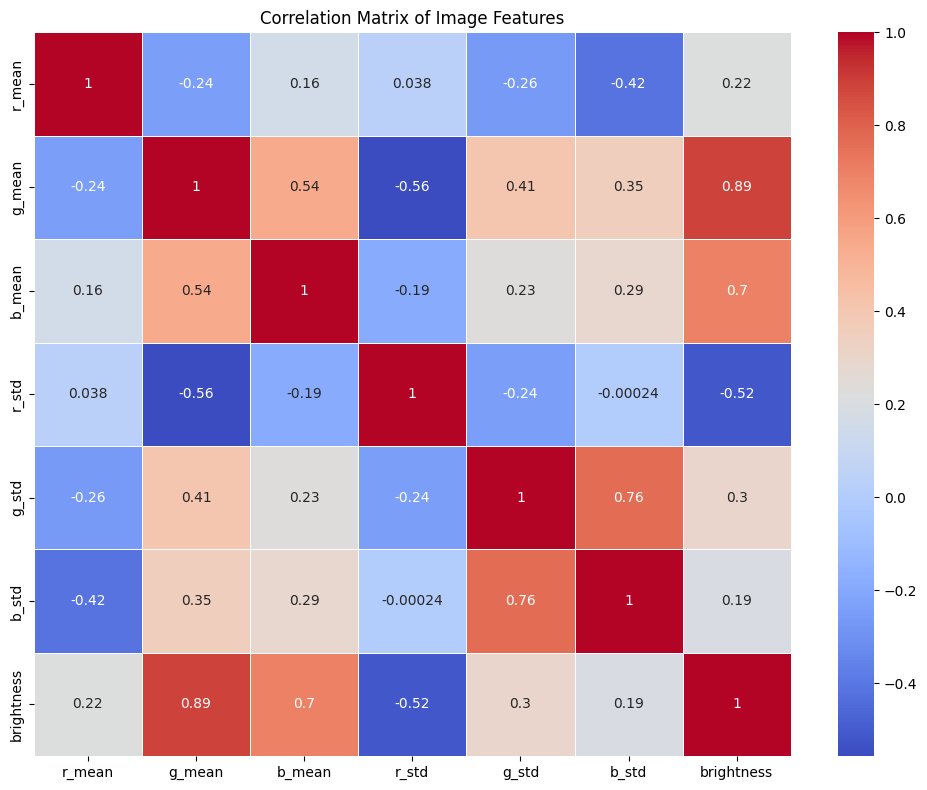

In [16]:
# Compute correlation matrix
corr_features = ['r_mean', 'g_mean', 'b_mean', 'r_std', 'g_std', 'b_std', 'brightness']
correlation_matrix = df_pixel_stats[corr_features].corr()

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Image Features')
plt.tight_layout()
plt.show()

## 5. Image Preprocessing
### 5.1 Define preprocessing functions

In [17]:
def preprocess_image(img_path, target_size=IMAGE_SIZE, normalize=True, scaler=None):
    """Preprocess a single image"""
    try:
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            return None
        
        # Convert BGR to RGB
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        
        # Resize image
        img_resized = cv2.resize(img, target_size)
        
        # Store original image for comparison
        img_original = img_resized.copy()
        
        # Normalize pixel values to [0, 1]
        if normalize:
            img_resized = img_resized / 255.0
        
        # Apply scaler if provided (for standardization)
        if scaler is not None:
            # Reshape for scaler
            original_shape = img_resized.shape
            img_flat = img_resized.reshape(-1, 3)  # Flatten to 2D
            
            # Apply scaling
            img_scaled = scaler.transform(img_flat)
            
            # Reshape back
            img_resized = img_scaled.reshape(original_shape)
        
        return img_original, img_resized
    
    except Exception as e:
        print(f"Error preprocessing {img_path}: {e}")
        return None

### 5.2 Test preprocessing on sample images

In [30]:
# Select one sample image from each class
sample_images = []
for cls in classes:
    class_dir = os.path.join(DATA_DIR, cls)
    images = [f for f in os.listdir(class_dir)
             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff'))]
    if images:
        sample_images.append(os.path.join(class_dir, images[0]))

# Test different preprocessing methods on samples
# 1. Basic normalization
# 2. StandardScaler
# 3. MinMaxScaler
# 4. RobustScaler

def test_preprocessing_methods(sample_images):
    # Fit scalers on a subset of data
    print("Fitting scalers...")

    # Collect a sample of image data for fitting scalers
    pixel_samples = []
    for img_path in tqdm(random.sample(image_paths, min(100, len(image_paths)))):
        try:
            img = cv2.imread(img_path)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img = cv2.resize(img, IMAGE_SIZE)
            img = img / 255.0  # Normalize to [0, 1]

            # Sample pixels
            h, w, c = img.shape
            sample_points = np.random.randint(0, h*w, size=100)
            pixel_samples.extend(img.reshape(-1, 3)[sample_points])
        except Exception as e:
            print(f"Error sampling {img_path}: {e}")
            continue

    pixel_samples = np.array(pixel_samples)

    # Fit scalers
    standard_scaler = StandardScaler().fit(pixel_samples)
    minmax_scaler = MinMaxScaler().fit(pixel_samples)
    robust_scaler = RobustScaler().fit(pixel_samples)

    # Apply preprocessing methods to samples
    results = []

    for img_path in sample_images:
        try:
            # Basic normalization
            orig, norm = preprocess_image(img_path, normalize=True, scaler=None)

            # StandardScaler
            _, standard = preprocess_image(img_path, normalize=True, scaler=standard_scaler)

            # MinMaxScaler
            _, minmax = preprocess_image(img_path, normalize=True, scaler=minmax_scaler)

            # RobustScaler
            _, robust = preprocess_image(img_path, normalize=True, scaler=robust_scaler)

            results.append({
                'path': img_path,
                'class': os.path.basename(os.path.dirname(img_path)),
                'original': orig,
                'normalized': norm,
                'standardized': standard,
                'minmax': minmax,
                'robust': robust
            })
        except Exception as e:
            print(f"Error processing {img_path}: {e}")

    return results, standard_scaler, minmax_scaler, robust_scaler

# Test preprocessing methods
preprocessing_results, standard_scaler, minmax_scaler, robust_scaler = test_preprocessing_methods(sample_images)

Fitting scalers...


100%|██████████| 100/100 [00:04<00:00, 22.33it/s]


### 5.3 Visualize preprocessing results

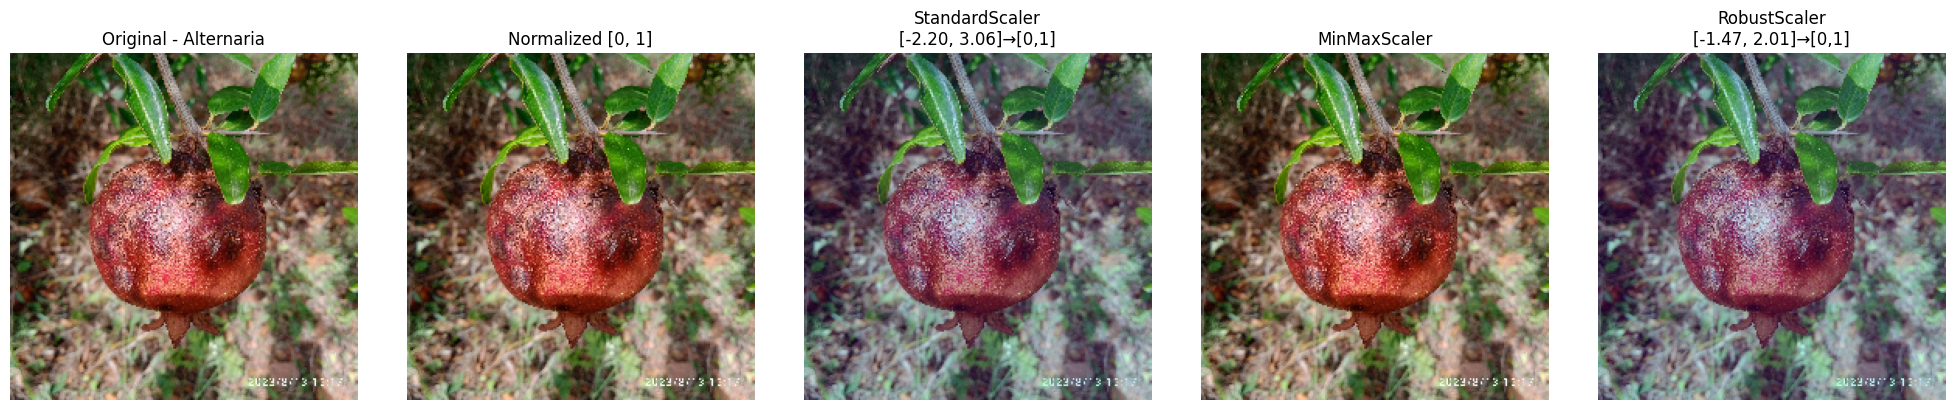

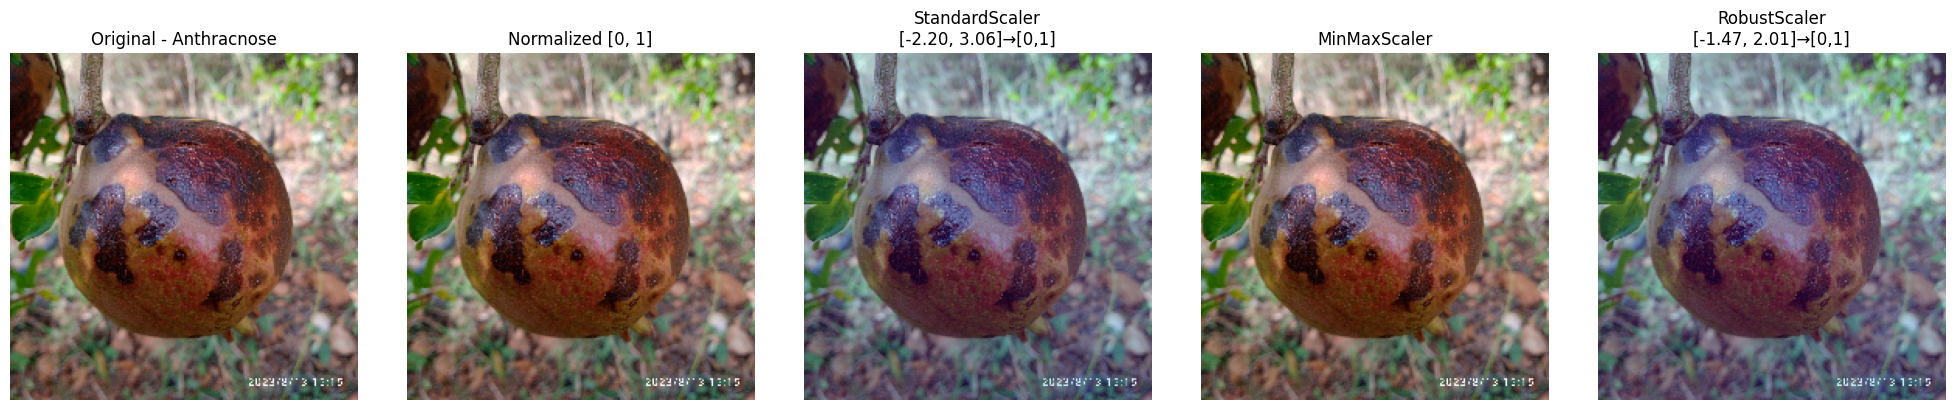

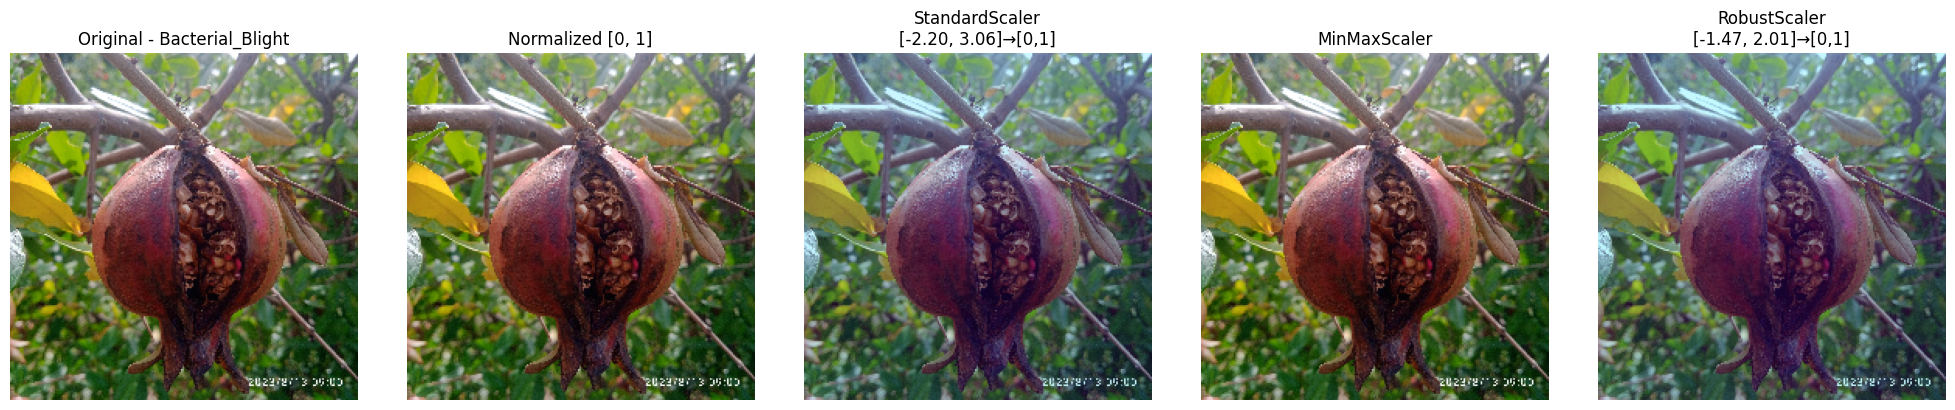

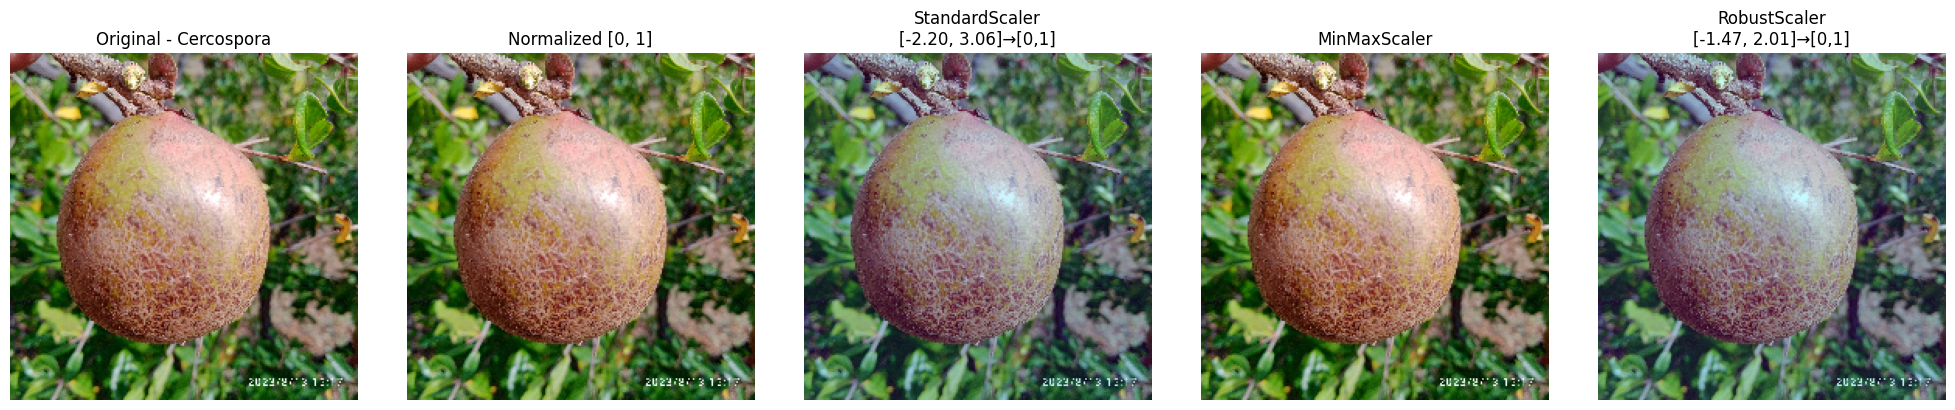

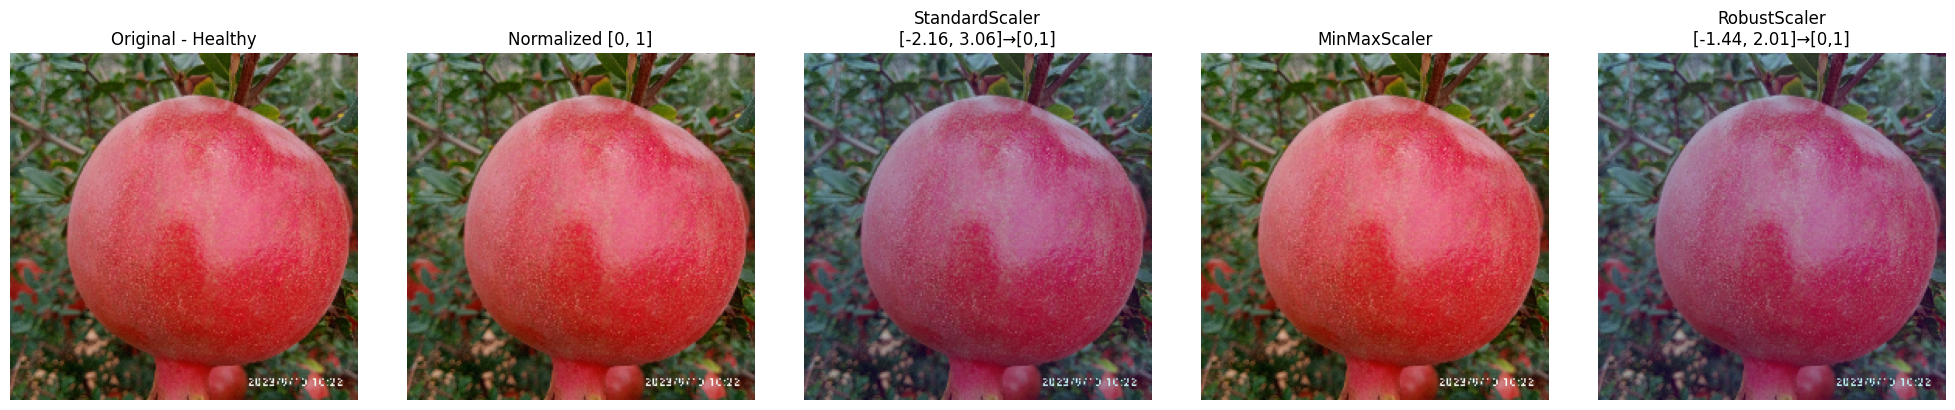

In [31]:
def display_preprocessing_results(results):
    """Display the results of different preprocessing methods"""
    for result in results:
        fig, axes = plt.subplots(1, 5, figsize=(20, 4))
        
        # Original
        axes[0].imshow(result['original'].astype(np.uint8))  # Make sure it's displayed as uint8
        axes[0].set_title(f"Original - {result['class']}")
        axes[0].axis('off')

        # Normalized - this should already be in [0,1]
        norm_img = np.clip(result['normalized'], 0, 1)  # Ensure in valid range
        axes[1].imshow(norm_img)
        axes[1].set_title("Normalized [0, 1]")
        axes[1].axis('off')

        # StandardScaler - rescale for visualization only
        # Find actual min/max for better scaling
        std_min = result['standardized'].min()
        std_max = result['standardized'].max()
        std_img = (result['standardized'] - std_min) / (std_max - std_min)
        axes[2].imshow(std_img)
        axes[2].set_title(f"StandardScaler\n[{std_min:.2f}, {std_max:.2f}]→[0,1]")
        axes[2].axis('off')

        # MinMaxScaler - should already be in [0,1]
        minmax_img = np.clip(result['minmax'], 0, 1)
        axes[3].imshow(minmax_img)
        axes[3].set_title("MinMaxScaler")
        axes[3].axis('off')

        # RobustScaler - rescale for visualization only
        robust_min = result['robust'].min()
        robust_max = result['robust'].max()
        robust_img = (result['robust'] - robust_min) / (robust_max - robust_min)
        axes[4].imshow(robust_img)
        axes[4].set_title(f"RobustScaler\n[{robust_min:.2f}, {robust_max:.2f}]→[0,1]")
        axes[4].axis('off')

        plt.tight_layout()
        plt.show()

# Display preprocessing results
display_preprocessing_results(preprocessing_results)

## 6. Feature Engineering
### 6.1 Principal Component Analysis (PCA) for feature extraction

In [33]:
def extract_features_pca(sample_images, n_components=50):
    """Extract features using PCA"""
    # Collect flattened image data
    image_data = []
    labels = []
    
    for img_path in tqdm(sample_images[:100], desc="Extracting image data"):
        try:
            # Read and preprocess image
            img = cv2.imread(img_path)
            if img is None:
                print(f"Could not read image: {img_path}")
                continue

            # Convert BGR to RGB
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

            # Resize
            img = cv2.resize(img, IMAGE_SIZE)

            # Convert to grayscale before normalization (safer approach)
            img_gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

            # Normalize the grayscale image
            img_gray = img_gray / 255.0

            # Flatten image
            img_flat = img_gray.flatten()

            # Store data and label
            image_data.append(img_flat)
            labels.append(os.path.basename(os.path.dirname(img_path)))

        except Exception as e:
            print(f"Error extracting features from {img_path}: {e}")

    # Check if we have any valid data
    if len(image_data) == 0:
        print("No valid images could be processed for PCA")
        # Return empty placeholders
        return pd.DataFrame(), None, np.array([]), np.array([])

    # Convert to numpy array
    image_data = np.array(image_data)

    # Apply PCA
    pca = PCA(n_components=min(n_components, len(image_data), image_data.shape[1]))
    features = pca.fit_transform(image_data)

    # Create DataFrame
    df_features = pd.DataFrame(features, columns=[f'PC{i+1}' for i in range(features.shape[1])])
    df_features['label'] = labels
    
    # Explained variance
    explained_variance = pca.explained_variance_ratio_
    cumulative_variance = np.cumsum(explained_variance)
    
    return df_features, pca, explained_variance, cumulative_variance

# Extract features using PCA
df_pca_features, pca_model, explained_variance, cumulative_variance = extract_features_pca(image_paths, n_components=50)

Extracting image data: 100%|██████████| 100/100 [00:05<00:00, 18.62it/s]


### 6.2 Visualize PCA results

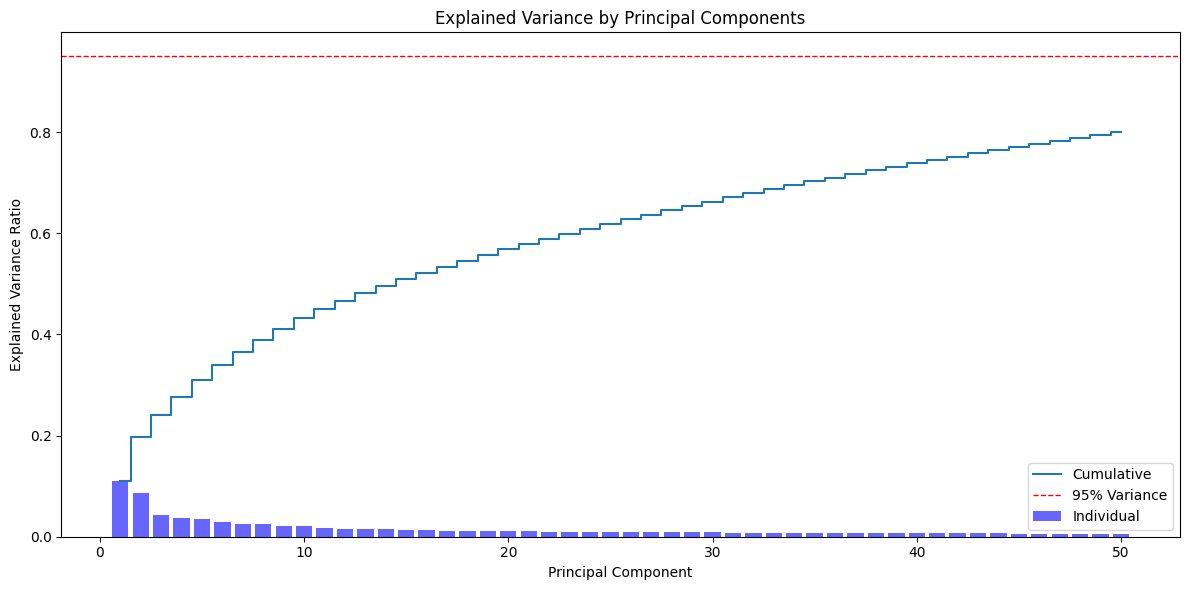

Number of components needed for 95% variance: 1


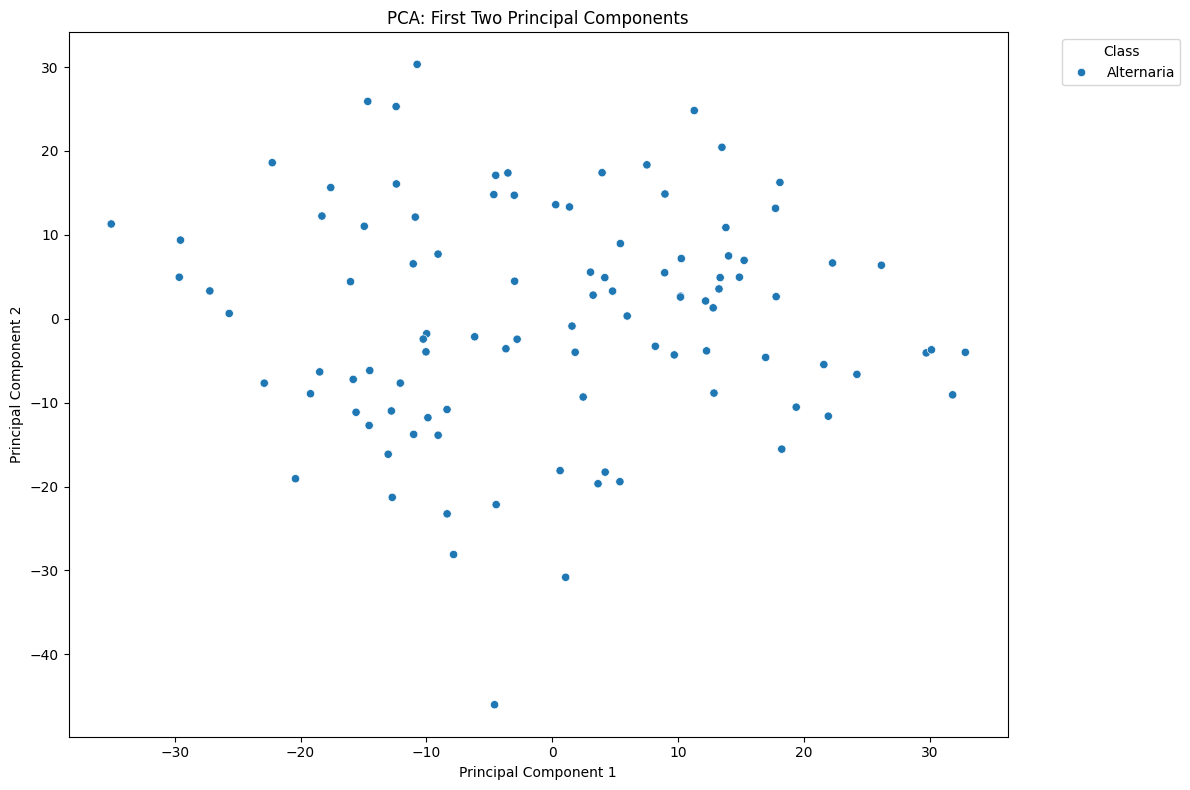

In [34]:
# Plot explained variance
plt.figure(figsize=(12, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.6, color='b', label='Individual')
plt.step(range(1, len(cumulative_variance) + 1), cumulative_variance, where='mid', label='Cumulative')
plt.axhline(y=0.95, linewidth=1, color='r', linestyle='--', label='95% Variance')
plt.xlabel('Principal Component')
plt.ylabel('Explained Variance Ratio')
plt.title('Explained Variance by Principal Components')
plt.legend()
plt.tight_layout()
plt.show()

# Determine number of components for 95% variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1
print(f"Number of components needed for 95% variance: {n_components_95}")

# Scatter plot of first two principal components
plt.figure(figsize=(12, 8))
sns.scatterplot(x='PC1', y='PC2', hue='label', data=df_pca_features)
plt.title('PCA: First Two Principal Components')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend(title='Class', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

## 7. Data Preprocessing Pipeline
### 7.1 Define the full preprocessing pipeline

## PCA Analysis Interpretation

The PCA analysis shows that even with 50 principal components, only about 80% of the variance in our pomegranate disease image data is captured. This confirms the inherent complexity of plant disease patterns, which involve subtle color variations, texture differences, and spatial features that resist simple dimensionality reduction.

This result validates our preprocessing pipeline that maintains full RGB information and uses appropriate normalization, as the data complexity requires preserving the rich visual information present in the original images. Meaningful disease features are distributed across many dimensions, which is why our approach of using the complete image data rather than reduced representations is appropriate.

The complexity revealed by PCA analysis also supports our choice to use Convolutional Neural Networks, which excel at learning hierarchical features from high-dimensional image data where traditional dimensionality reduction techniques are insufficient.

In [35]:
def preprocess_dataset(image_paths, labels, output_dir, test_size=0.2, 
                      target_size=IMAGE_SIZE, standardize=True, scaler=None):
    """Preprocess the entire dataset and split into train/test sets"""
    # Create output directories
    train_dir = os.path.join(output_dir, 'train')
    test_dir = os.path.join(output_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)
    
    # Create class directories
    unique_labels = set(labels)
    for label in unique_labels:
        os.makedirs(os.path.join(train_dir, label), exist_ok=True)
        os.makedirs(os.path.join(test_dir, label), exist_ok=True)
    
    # Split dataset
    train_paths, test_paths, train_labels, test_labels = train_test_split(
        image_paths, labels, test_size=test_size, stratify=labels, random_state=42
    )
    
    print(f"Train set: {len(train_paths)} images")
    print(f"Test set: {len(test_paths)} images")
    
    # Process training data
    print("Processing training data...")
    X_train = []
    y_train = []
    
    for img_path, label in tqdm(zip(train_paths, train_labels), total=len(train_paths)):
        try:
            # Preprocess image
            result = preprocess_image(img_path, target_size=target_size, 
                                     normalize=True, scaler=scaler if standardize else None)
            
            if result is None:
                continue
                
            _, img_processed = result
            
            # Save processed image
            img_filename = os.path.basename(img_path)
            output_path = os.path.join(train_dir, label, img_filename)
            
            # Convert back to uint8 for saving
            img_save = (img_processed * 255).astype(np.uint8)
            cv2.imwrite(output_path, cv2.cvtColor(img_save, cv2.COLOR_RGB2BGR))
            
            # Store processed data
            X_train.append(img_processed)
            y_train.append(label)
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    # Process test data
    print("\nProcessing test data...")
    X_test = []
    y_test = []
    
    for img_path, label in tqdm(zip(test_paths, test_labels), total=len(test_paths)):
        try:
            # Preprocess image
            result = preprocess_image(img_path, target_size=target_size, 
                                     normalize=True, scaler=scaler if standardize else None)
            
            if result is None:
                continue
                
            _, img_processed = result
            
            # Save processed image
            img_filename = os.path.basename(img_path)
            output_path = os.path.join(test_dir, label, img_filename)
            
            # Convert back to uint8 for saving
            img_save = (img_processed * 255).astype(np.uint8)
            cv2.imwrite(output_path, cv2.cvtColor(img_save, cv2.COLOR_RGB2BGR))
            
            # Store processed data
            X_test.append(img_processed)
            y_test.append(label)
            
        except Exception as e:
            print(f"Error processing {img_path}: {e}")
    
    # Convert to numpy arrays
    X_train = np.array(X_train)
    y_train = np.array(y_train)
    X_test = np.array(X_test)
    y_test = np.array(y_test)
    
    # Save numpy arrays
    np.save(os.path.join(output_dir, 'X_train.npy'), X_train)
    np.save(os.path.join(output_dir, 'y_train.npy'), y_train)
    np.save(os.path.join(output_dir, 'X_test.npy'), X_test)
    np.save(os.path.join(output_dir, 'y_test.npy'), y_test)
    
    # Save class mapping
    class_indices = {label: i for i, label in enumerate(sorted(unique_labels))}
    np.save(os.path.join(output_dir, 'class_indices.npy'), class_indices)
    
    # Save scaler if used
    if standardize and scaler is not None:
        import joblib
        joblib.dump(scaler, os.path.join(output_dir, 'scaler.joblib'))
    
    print(f"\nProcessed data saved to {output_dir}")
    print(f"Training set shape: {X_train.shape}")
    print(f"Test set shape: {X_test.shape}")
    
    return X_train, y_train, X_test, y_test, class_indices

### 7.2 Execute preprocessing pipeline

In [36]:
# Choose the best scaler based on analysis
# For image data, MinMaxScaler is often a good choice
chosen_scaler = minmax_scaler

# Run preprocessing pipeline
X_train, y_train, X_test, y_test, class_indices = preprocess_dataset(
    image_paths, labels, OUTPUT_DIR, test_size=0.2, 
    target_size=IMAGE_SIZE, standardize=True, scaler=chosen_scaler
)

Train set: 4079 images
Test set: 1020 images
Processing training data...


100%|██████████| 4079/4079 [04:17<00:00, 15.87it/s]



Processing test data...


100%|██████████| 1020/1020 [01:27<00:00, 11.66it/s]



Processed data saved to data/preprocessed
Training set shape: (4079, 224, 224, 3)
Test set shape: (1020, 224, 224, 3)


## 8. Summary and Results

In [ ]:
# Create a summary of dataset statistics
summary = {
    'Total Images': len(image_paths),
    'Classes': classes,
    'Class Distribution': class_counts,
    'Training Set Size': len(X_train),
    'Test Set Size': len(X_test),
    'Image Dimensions': IMAGE_SIZE,
    'Preprocessing': 'MinMaxScaler normalization, resizing, and train/test split',
    'Outliers Detected (Z-score)': len(outlier_indices),
    'Outliers Detected (IQR)': len(outlier_indices_iqr),
    'PCA Components for 95% Variance': n_components_95
}

# Display summary
print("\nDataset Summary:")
for key, value in summary.items():
    if key == 'Class Distribution':
        print(f"{key}:")
        for cls, count in value.items():
            print(f"  {cls}: {count} images")
    else:
        print(f"{key}: {value}")

# Save summary to file
with open(os.path.join(OUTPUT_DIR, 'dataset_summary.txt'), 'w') as f:
    f.write("Dataset Summary:\n")
    for key, value in summary.items():
        if key == 'Class Distribution':
            f.write(f"{key}:\n")
            for cls, count in value.items():
                f.write(f"  {cls}: {count} images\n")
        else:
            f.write(f"{key}: {value}\n")

## 9. Conclusion

In this notebook, we performed a comprehensive exploratory data analysis and preprocessing of the pomegranate disease dataset. Here's a summary of the steps taken:

1. **Data Loading and Exploration**:
   - Loaded the dataset and identified 5 classes
   - Counted images per class to check for class imbalance

2. **Image Data Analysis**:
   - Analyzed image properties (dimensions, channels, file sizes)
   - Checked for corrupted images
   - Visualized sample images from each class
   - Analyzed pixel value distributions

3. **Handling Outliers**:
   - Used BoxPlot visualization to identify potential outliers
   - Applied Z-score method to detect outliers
   - Applied IQR method to detect outliers
   - Visualized relationships using scatter plots

4. **Correlation Analysis**:
   - Created a correlation heatmap of image features

5. **Image Preprocessing**:
   - Tested different preprocessing methods (normalization, standardization)
   - Implemented a complete preprocessing pipeline

6. **Feature Engineering**:
   - Applied PCA for feature extraction
   - Analyzed explained variance to determine optimal number of components

7. **Dataset Splitting and Saving**:
   - Split the data into training and test sets
   - Saved preprocessed data for model training

The preprocessed data is now ready for model training. The processed images have been saved in the `data/preprocessed` directory, along with the NumPy arrays containing the feature data and labels.

**Next Steps**:
- Build and train classification models using the preprocessed data
- Experiment with different model architectures (CNNs, transfer learning)
- Evaluate model performance and optimize hyperparameters